# Learning a Stream with a Running Mean

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GalacticDynamics/localflowwalk/blob/main/docs/tutorials/stream_runningmean.ipynb)

Training the decoder in the autoencoder is 30x slower than any other step. While this decoder gives the most accurate results, if you need a faster method -- e.g. for an likelihood in an MCMC step -- then `localflowwalk` supports user-defined "decoders". Let's look at one built-in example.

In [1]:
import pathlib
import pickle

import galax.coordinates as gc
import galax.dynamics as gd
import galax.potential as gp
import jax
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

import quaxed.numpy as jnp
import unxt as u

import phasecurvefit as pcf

In [2]:
key = jr.key(201030)

## Data: a Stream

In [3]:
usys = u.unitsystems.galactic

# Progenitor Parameters
prog_w0 = gc.PhaseSpaceCoordinate(
    q=u.Q([10, 3, 5], "kpc"), p=u.Q([-4, 100, 4], "km/s"), t=u.Q(0.0, "Myr")
)
prog_mass = u.Quantity(2.5e4, "Msun")

# Stream Distribution Function
df = gd.FardalStreamDF()

# Potential
pot = gp.LMJ09LogarithmicPotential(
    v_c=u.Q(150, "km/s"),
    r_s=u.Q(2, "kpc"),
    q1=1.0,
    q2=1.3,
    q3=0.9,
    phi=u.Q(0, "deg"),
    units=usys,
)

# Mock stream generator (galax)
mockgen = gd.MockStreamGenerator(df, pot)

In [4]:
mockstream_path = pathlib.Path("mockstream.pkl")
mockstream_path.parent.mkdir(parents=True, exist_ok=True)

try:
    if mockstream_path.exists():
        with mockstream_path.open("rb") as handle:
            mockstream, prog = pickle.load(handle)  # noqa: S301
    else:
        raise FileNotFoundError(f"Missing {mockstream_path}")  # noqa: EM102, TRY003, TRY301
except Exception as exc:  # noqa: BLE001
    print(f"Loading failed ({exc!r}); running the simulation.")
    mockstream, prog = mockgen.run(
        rng,
        u.Q(jnp.linspace(0, 4, 4_000), "Gyr"),
        prog_w0,
        prog_mass,
    )
    mockstream = jax.block_until_ready(mockstream)
    with mockstream_path.open("wb") as handle:
        pickle.dump((mockstream, prog), handle)

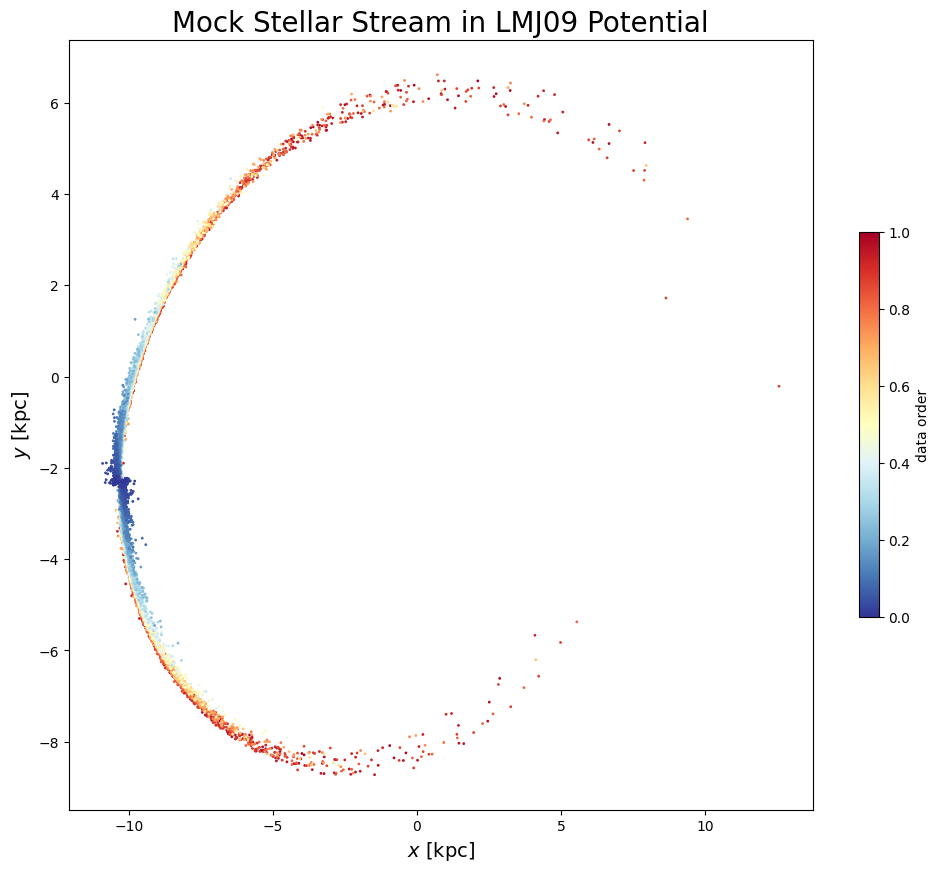

In [5]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
im = ax.scatter(
    np.array(mockstream.q.x),
    np.array(mockstream.q.y),
    s=1,
    c=jnp.linspace(1, 0, len(mockstream.q)),
    cmap="RdYlBu_r",
)
plt.colorbar(im, ax=ax, label="data order", shrink=0.5)
ax.set_xlabel(r"$x$ [kpc]", fontsize=14)
ax.set_ylabel(r"$y$ [kpc]", fontsize=14)
ax.set_title("Mock Stellar Stream in LMJ09 Potential", fontsize=20)
plt.show();

## Fitting $\gamma, \vec{x}$ for the Whole Stream

In [6]:
# Shuffle the data
key, subkey = jr.split(key)
order = jr.permutation(subkey, jnp.arange(len(mockstream.q.x)))

qs = {k: getattr(mockstream.q, k)[order] for k in mockstream.q.components}
ps = {k: getattr(mockstream.p, k)[order] for k in mockstream.p.components}

In [7]:
# Determine the starting index as the point closest to the progenitor
# Note the index must be static
start_idx = int(np.argmin(jnp.linalg.norm(mockstream.q[order] - prog.q, axis=1)))

# Walk configuration
config = pcf.WalkConfig(
    strategy=pcf.strats.KDTree(k=50),
    metric=pcf.metrics.AlignedMomentumDistanceMetric(),
)
metric_scale = u.Q(100, "kpc")
max_dist = u.Q(3, "kpc")


# Perform walk
walkresult = pcf.walk_local_flow(
    qs,
    ps,
    start_idx=start_idx,
    metric_scale=metric_scale,
    max_dist=max_dist,
    config=config,
    direction="both",
    metadata=pcf.StateMetadata(usys=usys),
)

# Train encoder & apply running mean function
key, model_key, train_key = jr.split(key, 3)
normalizer = pcf.nn.StandardScalerNormalizer(qs, ps)
model = pcf.nn.EncoderExternalDecoder(
    encoder=pcf.nn.OrderingNet(in_size=6, key=model_key),
    decoder=pcf.nn.RunningMeanDecoder(window_size=0.05),
    normalizer=normalizer,
)
result, opt_state, losses = pcf.nn.train_autoencoder(model, walkresult, key=train_key)

Training:   0%|          | 0/800 [00:00<?, ?epoch/s]

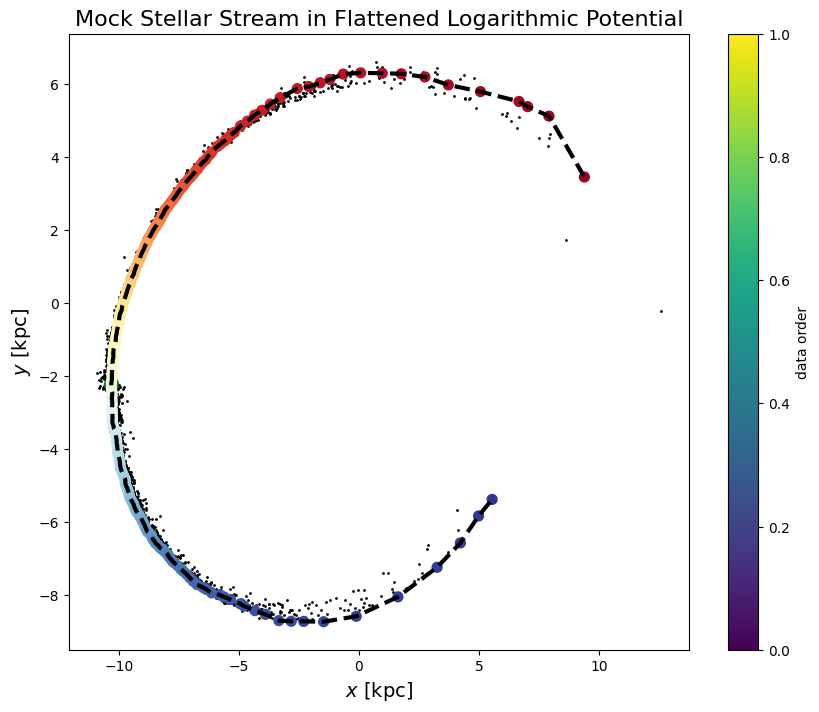

In [8]:
# ruff: fmt: off
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.scatter(qs["x"], qs["y"], s=1, c="k")
ax.scatter(
    [qs["x"][start_idx]], [qs["y"][start_idx]], s=100, c="green", label="Start Point"
)

ordering = walkresult.ordering
walk_qs = {k: v[ordering] for k, v in walkresult.positions.items()}
timeline = np.linspace(0, 1, len(ordering))
ax.scatter(walk_qs["x"], walk_qs["y"], s=50, c=timeline, cmap="RdYlBu")
ax.plot(walk_qs["x"], walk_qs["y"], c="k", lw=3, ls="--")

plt.colorbar(im, ax=ax, label="data order")
ax.set_xlabel(r"$x$ [kpc]", fontsize=14)
ax.set_ylabel(r"$y$ [kpc]", fontsize=14)
ax.set_title("Mock Stellar Stream in Flattened Logarithmic Potential", fontsize=16)
plt.show();

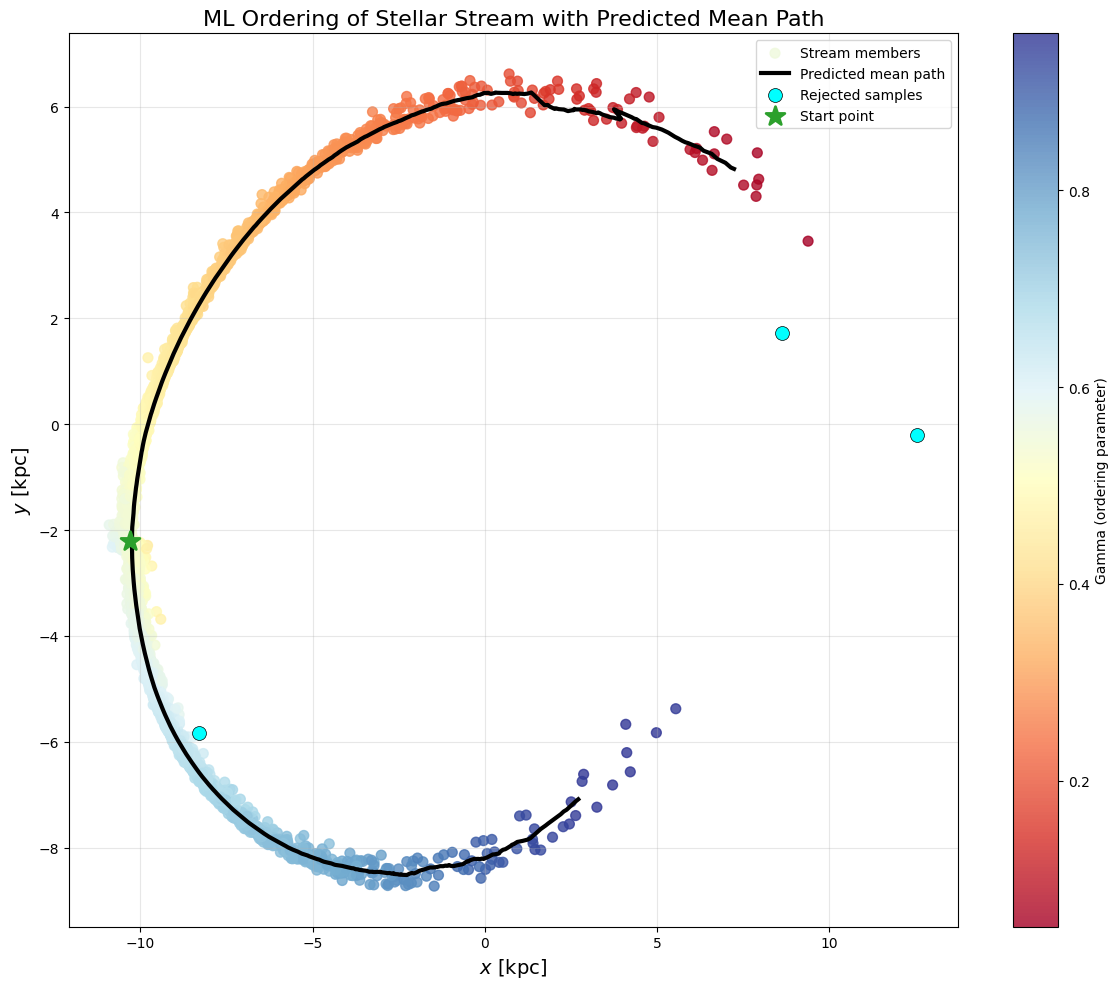

In [9]:
# Visualize the ML-filled path in 2D with mean path prediction
fig, ax = plt.subplots(figsize=(12, 10))

# all_gamma, all_probs = jax.vmap(model.encoder)(all_ws)
all_gamma, all_probs = result.model.encode(walkresult.positions, walkresult.velocities)
rejected_membership = all_probs < 0.9
qs_pred = result(jnp.linspace(0.06, 0.95, 1_000))

# Plot all points with gradient coloring
im = ax.scatter(
    np.asarray(qs["x"]),
    np.asarray(qs["y"]),
    s=50,
    c=np.asarray(all_gamma),
    cmap="RdYlBu",
    alpha=0.8,
    label="Stream members",
)

# Plot predicted mean path
ax.plot(
    np.asarray(qs_pred["x"]),
    np.asarray(qs_pred["y"]),
    c="k",
    lw=3,
    label="Predicted mean path",
)

# Mark rejected samples in cyan
ax.scatter(
    np.asarray(qs["x"][rejected_membership]),
    np.asarray(qs["y"][rejected_membership]),
    s=100,
    c="cyan",
    alpha=1.0,
    marker="o",
    edgecolors="black",
    linewidths=0.5,
    label="Rejected samples",
)

# Mark start point
ax.scatter(
    np.asarray(qs["x"][start_idx]),
    np.asarray(qs["y"][start_idx]),
    s=200,
    c="tab:green",
    marker="*",
    label="Start point",
    linewidths=2,
    zorder=5,
)

ax.set_xlabel(r"$x$ [kpc]", fontsize=14)
ax.set_ylabel(r"$y$ [kpc]", fontsize=14)
ax.set_title("ML Ordering of Stellar Stream with Predicted Mean Path", fontsize=16)
fig.colorbar(im, ax=ax, label="Gamma (ordering parameter)")
ax.legend(loc="upper right", fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();